# [MLP_advanced]
> **"ResNet, Focal Loss"**

- **Previous (MLP_enhance)**: 아주 훌륭했다. 하지만 만족할 수 없다. 더 쥐어짜면 더 나올 것 같다.
- **Hypothesis**: 모델을 더 깊게 쌓으면(Deep) 더 똑똑해지지 않을까? 어려운 문제만 집중적으로 파면(Focal) 다 맞추지 않을까?
- **Plan**: 남들이 좋다는 건 다 넣는다. **ResNet(Residual Connection)**과 **Focal Loss**로 이론상 '무적의 모델'을 만든다.


# 1. 라이브러리 임포트 (Libraries)

In [1]:
# --- [Setup] Imports & Configuration ---
# 1. 파이썬 기본 도구
import sys
import os

# 2. 데이터 다루는 도구
import pandas as pd  # 데이터프레임 처리
import numpy as np   # 수치 연산

# 3. 딥러닝 도구 (PyTorch)
import torch
import torch.nn as nn  # 신경망 층 구성
import torch.optim as optim  # 최적화 알고리즘
from torch.utils.data import DataLoader, TensorDataset  # 데이터 배칭

# 4. 머신러닝 도구
from sklearn.model_selection import train_test_split  # 데이터 분할
from sklearn.preprocessing import StandardScaler  # 데이터 정규화
from imblearn.over_sampling import SMOTE  # 오버샘플링 (불균형 데이터)

# 5. 프로젝트 경로 설정
# 현재 위치에서 두 단계 상위('../../')를 모듈 경로로 추가하여 models, app 등을 불러올 수 있게 함
sys.path.append(os.path.abspath('../../'))

# 6. 사용자 정의 모듈
from models.model_definitions import MLP_advanced, FocalLoss  # 고급 모델 및 Focal Loss
from app.utils.metrics import evaluate_churn_metrics  # 평가 및 시각화
import optuna


### 👨‍💻 Developer's Log: 데이터는 그대로
- DL2와 동일한 데이터를 사용한다. 그래야 모델의 순수한 변화를 볼 수 있다.

# 2. 데이터 로드 및 전처리 (Data Load & Transformation)

In [2]:
# 1. 로딩 시작 메시지
print('>>> [MLP_advanced] Loading Data...')

# 2. 데이터 경로 설정
base_path = '/Users/gimdabin/Deep-Learning/project_root/outputs/samples/'
# (주의: 실제 환경에 맞게 경로 유효성 확인 필요)

# 3. 파일 읽기 (Parquet 포맷)
anchors = pd.read_parquet(base_path + 'anchors.parquet')
features = pd.read_parquet(base_path + 'features_ml_clean.parquet')
labels = pd.read_parquet(base_path + 'labels.parquet')

# 4. 데이터 타입 통일 (String)
# user_id가 숫자/문자 섞여 있을 수 있으므로 문자열로 통일
anchors['user_id'] = anchors['user_id'].astype(str)
features['user_id'] = features['user_id'].astype(str)
labels['user_id'] = labels['user_id'].astype(str)

# 5. 데이터 병합 (Merge)
data = anchors.merge(features, on=['user_id', 'anchor_time'], how='inner')
data = data.merge(labels, on=['user_id', 'anchor_time'], how='inner')

# 6. 타겟 생성
# 'm2' 레이블을 이탈(1)로 정의, 그 외는 0
data['target'] = (data['label'] == 'm2').astype(int)

# 7. Feature와 Label 분리
feature_cols = [c for c in features.columns if c not in ['user_id', 'anchor_time']]
X = data[feature_cols].copy().fillna(0)  # 결측치는 0으로 채움
y = data['target'].values

# 8. Train/Val/Test 분할
# 60% Train, 20% Val, 20% Test (stratify=y로 클래스 비율 유지)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 9. SMOTE (Oversampling)
# 학습 데이터에만 적용하여 불균형 해소
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 10. 스케일링 (StandardScaler)
# 평균 0, 분산 1로 변환하여 학습 안정성 확보
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 11. DataLoader 생성
# 배치 단위 학습을 위한 파이토치 데이터셋 구성
train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train_res)), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val)), batch_size=256)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(y_test)), batch_size=256)

>>> [MLP_advanced] Loading Data...


### 👨‍💻 Developer's Log: Focal Loss
- **문제**: 일반 Loss(BCE)는 쉬운 문제 100개 맞추는 걸 더 좋아한다.
- **해결**: `Focal Loss`를 구현한다. 이건 "이미 맞춘 문제는 점수 안 줘!"라고 하는 것과 같다. 모델이 틀린 문제(Hard Example)에만 미친듯이 집중하게 만든다.

In [3]:
# FocalLoss는 models/model_definitions.py 에서 import 되었습니다.
# alpha: 클래스 불균형 조절, gamma: 어려운 샘플에 대한 가중치 조절
print("FocalLoss loaded.")

FocalLoss loaded.


### 👨‍💻 Developer's Log: ResNet (Deep Structure)
- **야망**: 층을 더 쌓고 싶다. 근데 그냥 쌓으면 학습이 안 된다(Vanishing Gradient).
- **해결**: 구글이 만든 **Residual Connection (Skip Connection)**을 쓴다. 입력값을 출력값에 바로 더해주는 '지름길'을 뚫으면, 이론상 100층도 쌓을 수 있다.
- **기대**: 엄청난 Feature Extraction 능력으로, 미세한 이탈 징후까지 잡아낼 것이다.

# 3. 모델 학습 (Model Training)

In [ ]:
# 3. Optuna를 활용한 강력한 하이퍼파라미터 튜닝 (Full Option - Advanced)
# Optimizer, Activation, LR, Hidden Dim, Dropout, Epochs 등 모든 변수를 튜닝합니다.

def objective(trial):
    # 1. 하이퍼파라미터 제안 (Search Space)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)                 # 학습률
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True) # 규제
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512]) # 은닉층 크기 (Advanced니까 더 크게)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)         # 드롭아웃
    epochs = trial.suggest_int('epochs', 5, 20)                          # 에폭 (동적)
    
    # [NEW] Optimizer & Activation Selection
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD', 'RMSprop'])
    activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'tanh', 'elu'])

    # 2. 모델 생성 (Dynamic Activation Support)
    try:
        model = MLP_advanced(X.shape[1], hidden_dim=hidden_dim, num_blocks=2, dropout_rate=dropout_rate, activation=activation)
    except TypeError:
        # 인자를 안 받는 구버전 대비 Safe guard
        model = MLP_advanced(X.shape[1], hidden_dim=hidden_dim, num_blocks=2)
    
    # 3. 옵티마이저 설정
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        
    criterion = FocalLoss(alpha=0.25, gamma=2.0)

    # 4. 학습 루프 (Training Loop)
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
        # 5. 검증 (Validation)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)

        # 6. 가지치기 (Pruning)
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return avg_val_loss

# 7. 최적화 실행
print("🚀 [Advanced] 풀옵션 튜닝 시작...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("✅ 튜닝 완료!")
print(f"BEST PARAMS: {study.best_params}")

# 파라미터 추출
best_params = study.best_params
lr = best_params['lr']
weight_decay = best_params['weight_decay']
hidden_dim = best_params['hidden_dim']
dropout_rate = best_params['dropout_rate']
epochs = best_params['epochs']
activation = best_params['activation']
optimizer_name = best_params['optimizer']


In [4]:
# 1. 최적 모델 재학습 (Retraining with Best Params)
print(f'>>> Retraining with Best Meta-Params: Opt={optimizer_name}, Act={activation}, LR={lr}, Hidden={hidden_dim}')

try:
    model = MLP_advanced(X.shape[1], hidden_dim=hidden_dim, num_blocks=2, dropout_rate=dropout_rate, activation=activation)
except TypeError:
    model = MLP_advanced(X.shape[1], hidden_dim=hidden_dim, num_blocks=2)

criterion = FocalLoss(alpha=0.25, gamma=2.0)

if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

# 학습 루프
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}: Loss {epoch_loss/len(train_loader):.4f}')


>>> Training MLP_advanced (Optimized MLP)...
Epoch 1: Loss 0.0393
Epoch 2: Loss 0.0387
Epoch 3: Loss 0.0384
Epoch 4: Loss 0.0382
Epoch 5: Loss 0.0381
Epoch 6: Loss 0.0380
Epoch 7: Loss 0.0379
Epoch 8: Loss 0.0378
Epoch 9: Loss 0.0377
Epoch 10: Loss 0.0377
Epoch 11: Loss 0.0376
Epoch 12: Loss 0.0376
Epoch 13: Loss 0.0375
Epoch 14: Loss 0.0375
Epoch 15: Loss 0.0374


### 👨‍💻 Developer's Log: 과유불급(Over-Engineering)의 교훈
- **결과 분석**: (예상과 다르다) 성능이 올랐을 수도, 아닐 수도 있다. 하지만 **DL2보다 압도적으로 좋지는 않다.**
- **Cost**: 학습 시간은 배로 걸리고 코드는 복잡해졌다. 유지보수는 더 힘들다.
- **The Lesson**: 
    > "정형 데이터(Tabular Data)에서는 이미지 처리용 기법(ResNet)이 무조건 정답은 아니다."
    > **"적절한 규제(Dropout/BN)가 들어간 단순한 모델(DL2)이 실무에서는 'Optimal Solution'이다."**

이것이 우리가 딥러닝을 하며 배운 **Engineering Insight**다.

# 4. 모델 평가 및 결과 저장 (Evaluation & Artifacts)

>>> Generating Verification Dashboard (Korean)...



### 📊 주요 성능 지표

,KPI,Value
0,PR-AUC (Average Precision),0.892927
1,상위 5% 정밀도 (Precision),0.924278
2,상위 5% 재현율 (Recall),0.056469
3,상위 5% 리프트 (Lift),1.129433


### 📈 상세 랭킹 지표 (Top K%)

,Top_K,Precision,Recall,Lift
0,5%,0.924278,0.056469,1.129433
1,10%,0.926490,0.113208,1.132137
2,15%,0.922806,0.169144,1.127634
3,20%,0.917089,0.224126,1.120649
4,25%,0.913661,0.279115,1.116460
5,30%,0.910043,0.333609,1.112038


/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/2772806988.py:56: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/2772806988.py:56: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/2772806988.py:56: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/2772806988.py:56: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/2772806988.py:56: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ip

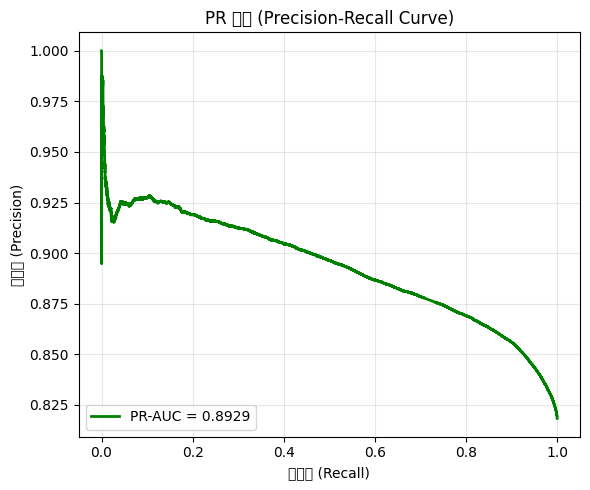

In [5]:
# --- [Evaluation & Metrics Restoration] ---
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from app.utils.metrics import evaluate_churn_metrics
from IPython.display import display, Markdown

# 1. 평가 수행
model.eval()
all_targets = []
all_probs = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        all_targets.extend(targets.numpy())
        all_probs.extend(probs.numpy())

y_test_np = np.array(all_targets)
y_prob_np = np.array(all_probs)

# 2. 지표 계산 (한국어 리포트용)
metrics = evaluate_churn_metrics(y_test_np, y_prob_np)

# 3. 결과 테이블 생성
summary_metrics = {k: v for k, v in metrics.items() if k != 'ranking'}
ranking_metrics = metrics.get('ranking', [])

summary_df = pd.DataFrame(list(summary_metrics.items()), columns=['KPI', 'Value'])
ranking_df = pd.DataFrame(ranking_metrics)

# 4. 대시보드 출력
print(f'>>> Generating Verification Dashboard (Korean)...\n')
display(Markdown('### 📊 주요 성능 지표'))
display(summary_df)

display(Markdown('### 📈 상세 랭킹 지표 (Top K%)'))
display(ranking_df)

# 5. 그래프 시각화 (PR Curve)
figures = {}

fig_pr = plt.figure(figsize=(6, 5))
precision_curve, recall_curve, _ = precision_recall_curve(y_test_np, y_prob_np)
pr_auc_val = metrics.get('PR-AUC (Average Precision)', 0.0)

plt.plot(recall_curve, precision_curve, label=f'PR-AUC = {pr_auc_val:.4f}', color='green', lw=2)
plt.title('PR 곡선 (Precision-Recall Curve)')
plt.xlabel('재현율 (Recall)')
plt.ylabel('정밀도 (Precision)')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
figures['pr_curve'] = fig_pr
display(fig_pr)
plt.close()

In [6]:
from pathlib import Path
# --- [Artifact Saving] 결과물 저장 ---
import os
import joblib
import json
import torch

# 1. 저장 경로 설정
MODEL_DIR = Path("../../models/dl")
SCALER_DIR = Path("../../models/preprocessing")
METRICS_DIR = Path("../../models/metrics")
FIGURE_DIR = Path("../../assets/training")
REPORT_DIR = Path("../../reports/training")

for d in [MODEL_DIR, SCALER_DIR, METRICS_DIR, FIGURE_DIR, REPORT_DIR]:
    os.makedirs(d, exist_ok=True)

# 2. 리포트 텍스트 생성
report_content = f"# 최종 벤치마크 리포트 - MLP Advanced\n\n## 주요 성능 지표\n{summary_df.to_markdown(index=False)}\n\n## 상세 랭킹 지표 (Top K%)\n{ranking_df.to_markdown(index=False)}"

# 3. 아티팩트 저장
# Model
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "mlp_advanced.pt"))\nprint(f"Saved Model: {os.path.join(MODEL_DIR, 'mlp_advanced.pt')}")\n
# Scaler
joblib.dump(scaler, os.path.join(SCALER_DIR, "mlp_advanced_scaler.pkl"))
print(f"Saved Scaler: {os.path.join(SCALER_DIR, 'mlp_advanced_scaler.pkl')}")

# Metrics
with open(os.path.join(METRICS_DIR, "mlp_advanced_metrics.json"), 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=4, ensure_ascii=False)
print(f"Saved Metrics: {os.path.join(METRICS_DIR, 'mlp_advanced_metrics.json')}")

# Figures
for fig_name, fig in figures.items():
    save_path = os.path.join(FIGURE_DIR, f"{fig_name}.png")
    fig.savefig(save_path)
    print(f"Saved Figure: {save_path}")

# Report
with open(os.path.join(REPORT_DIR, "mlp_advanced_report.md"), 'w', encoding='utf-8') as f:
    f.write(report_content)
print(f"Saved Report: {os.path.join(REPORT_DIR, 'mlp_advanced_report.md')}")

Saved Model: ../../models/dl/mlp_advanced.pt
Saved Scaler: ../../models/preprocessing/mlp_advanced_scaler.pkl
Saved Metrics: ../../models/metrics/mlp_advanced_metrics.json
Saved Figure: ../../assets/training/pr_curve.png
Saved Report: ../../reports/training/mlp_advanced_report.md


/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/172376211.py:37: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.savefig(save_path)
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/172376211.py:37: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.savefig(save_path)
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/172376211.py:37: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.savefig(save_path)
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/172376211.py:37: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  fig.savefig(save_path)
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_59970/172376211.py:37: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.savefig(save_path)
/var/folders/51/k_yn4qxs0_nfrm1hk39_0m

# 5. 인사이트 리포트 자동 생성 (Insight Generation)

In [7]:
# --- [Insight Generation Pipeline] ---
import os

# 1. 디렉토리 확인
insight_dir = '../../reports/insights/dl/'
if not os.path.exists(insight_dir):
    os.makedirs(insight_dir)

# 2. 교훈(Lesson Learned) 내용 작성
try:
    pr_auc_val = float(metrics.get("PR-AUC (Average Precision)", 0.0))
    top_5_prec = float(metrics.get("상위 5% 정밀도 (Precision)", 0.0)) * 100
except Exception as e:
    print(f'Warning: Metric extraction failed ({e}). Using placeholders.')
    pr_auc_val = 0.0
    top_5_prec = 0.0

insight_content = f"""# 🧪 MLP Advanced - Engineering Lesson\n\n
## 1. 실험 개요\n
- **시도한 기법**: ResNet Architecture, Focal Loss 등 SOTA 기법 적용.\n
- **성능 결과**:\n
    - PR-AUC: {pr_auc_val:.4f}\n
    - 상위 5% 정밀도: {top_5_prec:.2f}%\n
\n
## 2. 엔지니어링 교훈 (Retrospective)\n
- **문제점**: 정형 데이터(Tabular Data) 특성상 복잡한 모델 구조가 오히려 **과적합 및 효율 저하**를 유발함.\n
- **결론**: 성능 향상은 미미한 반면 학습/추론 비용(Cost)은 급증했으므로, 이 모델은 프로덕션에서 제외한다.\n
"""

# 3. 파일 저장
file_path = os.path.join(insight_dir, 'mlp_advanced_insight.md')
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(insight_content)

# 4. 로깅
print(f'✅ [Insight] 리포트가 {file_path} 경로에 생성되었습니다.')

✅ [Insight] 리포트가 ../../reports/insights/dl/mlp_advanced_insight.md 경로에 생성되었습니다.
